In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def build_gaussian_pyramid(img, sigma, n_layers):
    pyramid = [img]
    for _ in range(1, n_layers):
        img = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma)
        img = cv2.pyrDown(img)
        pyramid.append(img)
    return pyramid

def visualize_pyramid(pyramid):
    for img in pyramid:
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

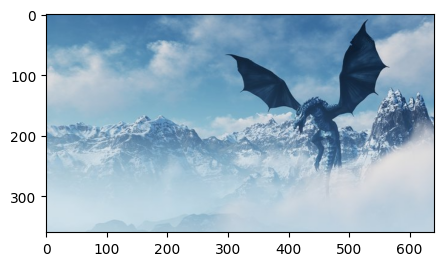

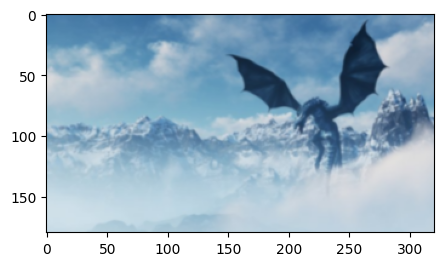

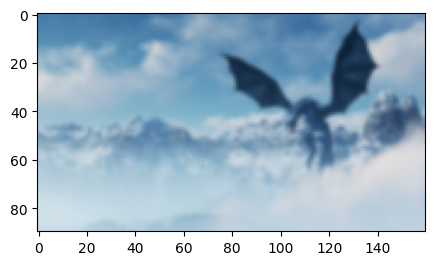

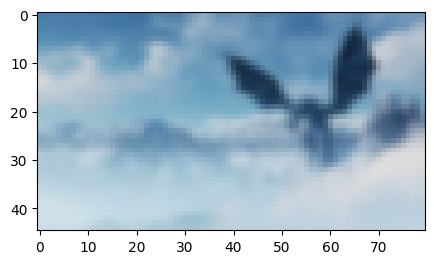

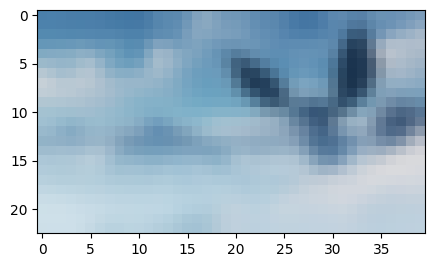

In [2]:
img = cv2.imread('experiment_image.png')
pyramid = build_gaussian_pyramid(img, sigma=1, n_layers=5)
visualize_pyramid(pyramid)

In [3]:
def build_laplacian_pyramid(img, sigma, n_layers):
    gaussian_pyramid = build_gaussian_pyramid(img, sigma, n_layers)
    laplacian_pyramid = []
    for i in range(n_layers - 1):
        current = gaussian_pyramid[i]
        next = gaussian_pyramid[i + 1]
        next_up = cv2.pyrUp(next, dstsize=current.shape[:2][::-1])  
        laplacian = cv2.subtract(current, next_up) 
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1]) 
    return laplacian_pyramid

In [4]:
def visualize_laplacian_pyramid(pyramid):
    for layer in pyramid:
        normalized_layer = cv2.normalize(layer, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        normalized_layer = np.uint8(normalized_layer)  
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(normalized_layer, cv2.COLOR_BGR2RGB))
        plt.show()

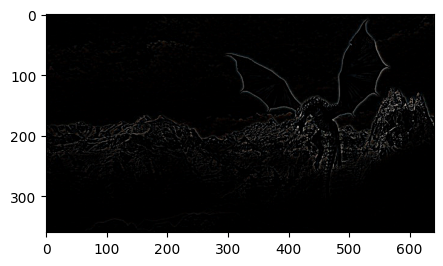

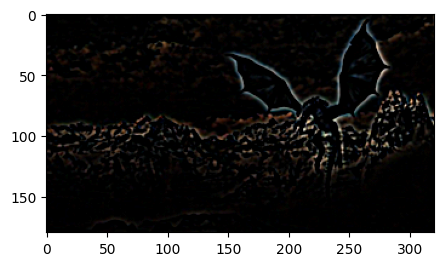

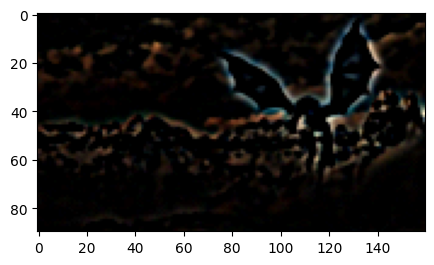

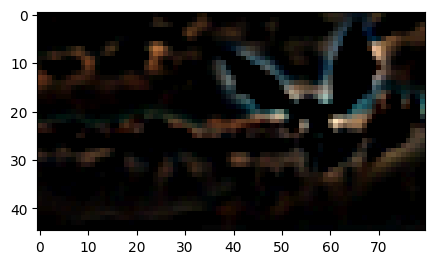

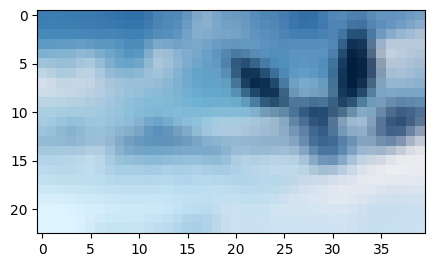

In [5]:
img = cv2.imread('experiment_image.png') 
if img is None:
    print("Ошибка загрузки изображения. Проверьте путь к файлу.")
else:
    laplacian_pyramid = build_laplacian_pyramid(img, sigma=1, n_layers=5)
    visualize_laplacian_pyramid(laplacian_pyramid)

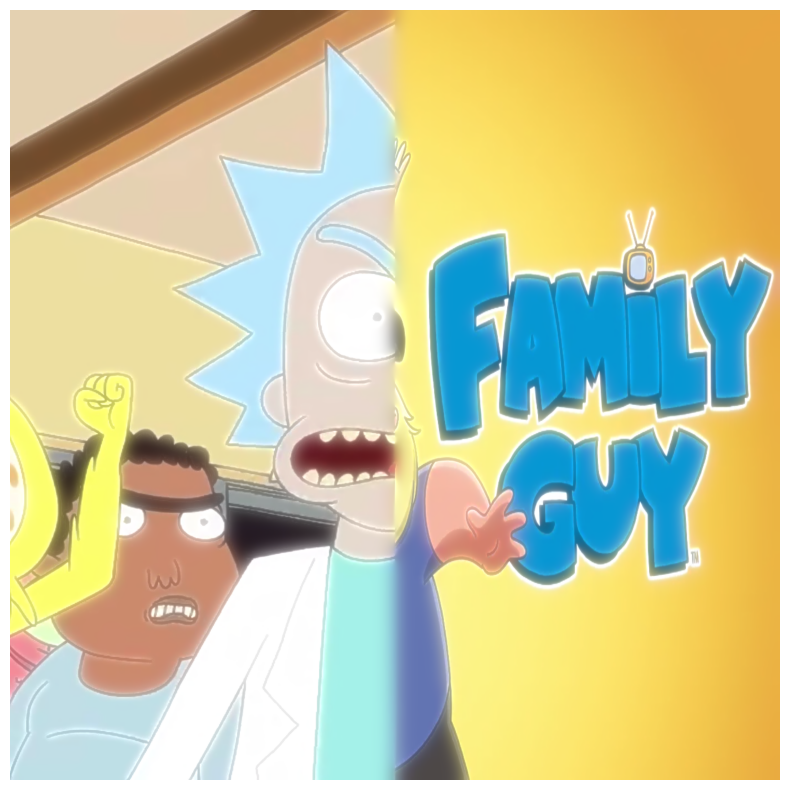

In [6]:
def blend_images(image1, image2, mask, sigma, n_layers):
    # Бинаризация маски
    mask = (mask > 128).astype('uint8') * 255
    laplacian_pyramid_1 = build_laplacian_pyramid(image1, sigma, n_layers)
    laplacian_pyramid_2 = build_laplacian_pyramid(image2, sigma, n_layers)
    gaussian_pyramid_mask = build_gaussian_pyramid(mask, sigma, n_layers)
    blended_pyramid = []
    for l1, l2, gm in zip(laplacian_pyramid_1, laplacian_pyramid_2, gaussian_pyramid_mask):
        gm_3d = np.repeat(gm[:, :, np.newaxis], 3, axis=2)  # Преобразование маски в трехканальный формат
        blended = l1 * (gm_3d / 255) + l2 * (1 - gm_3d / 255)
        blended_pyramid.append(blended)
    blended_image = blended_pyramid[-1]
    for i in range(n_layers-1, 0, -1):
        up_size = blended_pyramid[i-1].shape[1], blended_pyramid[i-1].shape[0] # Размер следующего слоя в пирамиде
        blended_image = cv2.pyrUp(blended_image, dstsize=up_size) # Увеличиваем с явным указанием размера

        if blended_image.shape[:2] != blended_pyramid[i-1].shape[:2]:
            blended_image = cv2.resize(blended_image, (blended_pyramid[i-1].shape[1], blended_pyramid[i-1].shape[0]))
        
        blended_image = cv2.add(blended_image, blended_pyramid[i-1])
    return blended_image

image1 = cv2.imread('1.png')
image2 = cv2.imread('2.png')

if image1 is None or image2 is None:
    raise Exception("Одно из изображений не было загружено. Проверьте пути к файлам.")

image2_resized = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

mask = np.zeros(image1.shape[:2], dtype=np.uint8)
mask[:, :mask.shape[1] // 2] = 255  # Левая половина маски белая, правая чёрная

blended_image = blend_images(image1, image2_resized, mask, sigma=1, n_layers=5)

blended_image_uint8 = cv2.convertScaleAbs(blended_image)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(blended_image_uint8, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.show()